<h1>Retired People and “Retired Places”: Italy, Data Cleaning<span class="tocSkip"></span></h1>
<div class="toc">
  <ol class="toc-item">
    <li>
      <span>
        <a href="#Loading-raw-tables" data-toc-modified-id="Loading-raw-tables-1">
          <span class="toc-item-num"></span>Loading raw tables
        </a>
      </span>
    </li>
    <li>
      <span>
        <a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-2">
          <span class="toc-item-num"></span>Data cleaning 
        </a>
      </span>
    </li>
  </ol>
</div>





## Loading raw tables <a id="Loading-raw-tables"></a>


In [1]:
import pandas as pd
from pathlib import Path
import geopandas as gpd

print('Libraries are downloaded')

Libraries are downloaded


In [2]:
PROJECT_ROOT = Path("..").resolve().parent
RAW = PROJECT_ROOT / "data" / "raw"

# path for cleaned data
PROCESSED = PROJECT_ROOT / "data" / "processed"
PROCESSED.mkdir(parents=True, exist_ok=True)

In [3]:
pop_reg_it = pd.read_csv(
    RAW / "popolazione_2025_it_regioni.csv",  
    sep=";",        
    skiprows=1,    
    encoding="utf-8"
)
display(pop_reg_it.head())

,Codice regione,Regione,Età,Totale maschi,Totale femmine,Totale
0,13,Abruzzo,0.0,3842.0,3577.0,7419.0
1,13,Abruzzo,1.0,4010.0,3653.0,7663.0
2,13,Abruzzo,2.0,4260.0,3873.0,8133.0
3,13,Abruzzo,3.0,4298.0,4163.0,8461.0
4,13,Abruzzo,4.0,4456.0,4163.0,8619.0


In [4]:
# load raw Excel without headers to inspect structure
homes_raw = pd.read_excel(
    RAW / "abitazioni_occupate_non_occupate_reg.xlsx",
    sheet_name=0,
    header=None
)

display(homes_raw.head(15))


,0,1,2,3
0,Abitazioni occupate e non occupate - comuni,NaN,NaN,NaN
1,Frequenza: Annuale,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,Anno,2021,2021,2021
4,Indicatore,Abitazioni occupate al 31 dicembre,Abitazioni non occupate al 31 dicembre,Abitazioni al 31 dicembre
5,Anno base,,,
6,Unità di misura,,,
7,Unità di moltiplicazione,,,
8,Territorio,,,
9,Piemonte,1964108,827768,2791876


In [5]:
gdf = gpd.read_file(RAW / "Reg01012025_g_WGS84.shp")
gdf.to_file("italy_regions.geojson", driver="GeoJSON")

gdf.head()

,COD_RIP,COD_REG,DEN_REG,Shape_Leng,Shape_Area,geometry
0,1,1,Piemonte,1.204253e+06,2.538884e+10,"POLYGON ((457423.465 5145719.795, 457503.63 51..."
1,1,2,Valle d'Aosta,3.068811e+05,3.260045e+09,"POLYGON ((389617.651 5093644.156, 389835.65 50..."
2,1,3,Lombardia,1.380027e+06,2.386128e+10,"MULTIPOLYGON (((485366.17 4984899.483, 485306...."
3,2,4,Trentino-Alto Adige,7.818018e+05,1.360618e+10,"POLYGON ((743539.748 5219742.292, 744116.845 5..."
4,2,5,Veneto,1.033420e+06,1.835382e+10,"POLYGON ((768720.205 5175392.996, 769182.105 5..."


In [6]:
# check that all regions are present
gdf.shape

(20, 6)

Check the current Coordinate Reference System (CRS). This is important because most web maps and GeoJSON files expect WGS84 (EPSG:4326). If the shapefile is in a different CRS (e.g. UTM), we need to reproject it before exporting and using it in the Streamlit choropleth map.

In [7]:
gdf.crs


<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
# Reproject the shapefile to WGS84 (EPSG:4326), i.e. latitude/longitude in degrees.
# Web maps and most GeoJSON-based tools expect coordinates in EPSG:4326,
# not in projected systems like UTM (EPSG:32632), which use metres.
gdf_4326 = gdf.to_crs(epsg=4326)

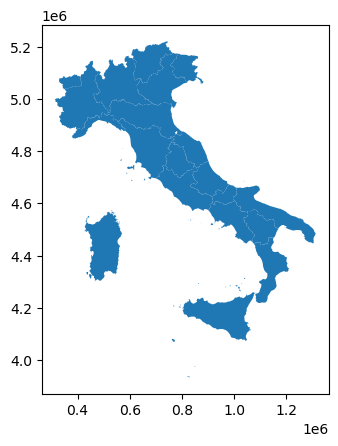

In [9]:
gdf.plot();


In [10]:
# Export the reprojected layer to GeoJSON.
out_path = PROCESSED / "italy_regions.geojson"
gdf_4326.to_file(out_path, driver="GeoJSON")

print(f"saved to: {out_path}")

saved to: /Users/eugenia/Desktop/Open Access/project/retired_places/data/processed/italy_regions.geojson


## Data cleaning <a id="Data-cleaning"></a>


### Adjusting columns names 

In [11]:
# Keep only the data rows starting from the first region 
homes_it_clean = homes_raw.iloc[9:, :4].copy()

# Assign clean column names
homes_it_clean.columns = ["region", "homes_occupied", "homes_unoccupied", "homes_total"]

# Reset index
homes_it_clean = homes_it_clean.reset_index(drop=True)

# Final check
display(homes_it_clean.head())


,region,homes_occupied,homes_unoccupied,homes_total
0,Piemonte,1964108,827768,2791876
1,Valle d'Aosta / Vallée d'Aoste,59616,75948,135564
2,Liguria,746686,431321,1178007
3,Lombardia,4415364,1184728,5600092
4,Trentino Alto Adige / Südtirol,463305,219888,683193


In [12]:
# translare column names to unify the language
pop_reg_it_clean = pop_reg_it.copy()
pop_reg_it_clean.columns = ["region_code", "region", "age", "pop_male", "pop_female", "pop_total"]

pop_reg_it_clean.head()

,region_code,region,age,pop_male,pop_female,pop_total
0,13,Abruzzo,0.0,3842.0,3577.0,7419.0
1,13,Abruzzo,1.0,4010.0,3653.0,7663.0
2,13,Abruzzo,2.0,4260.0,3873.0,8133.0
3,13,Abruzzo,3.0,4298.0,4163.0,8461.0
4,13,Abruzzo,4.0,4456.0,4163.0,8619.0


### Changing data types

In [13]:
print("=== homes_it_clean: dtypes ===")
print(homes_it_clean.dtypes)
print("\n")

print("=== pop_reg_it_clean: dtypes ===")
print(pop_reg_it_clean.dtypes)


=== homes_it_clean: dtypes ===
region              object
homes_occupied      object
homes_unoccupied    object
homes_total         object
dtype: object


=== pop_reg_it_clean: dtypes ===
region_code     object
region          object
age            float64
pop_male       float64
pop_female     float64
pop_total      float64
dtype: object


In [14]:
# Housing counts in homes_it  → Int64
housing_numeric_cols = ["homes_occupied", "homes_unoccupied", "homes_total"]

for col in housing_numeric_cols:
    homes_it_clean[col] = (
        pd.to_numeric(homes_it_clean[col], errors="coerce")  
        .round()
        .astype("Int64")                              
    )

# Population counts in pop_reg_it → Int64
population_numeric_cols = ["region_code", "age", "pop_male", "pop_female", "pop_total"]

for col in population_numeric_cols:
    pop_reg_it[col] = (
        pd.to_numeric(pop_reg_it_clean[col], errors="coerce")
        .round()
        .astype("Int64")
    )

print("=== homes_it_clean: dtypes after conversion ===")
print(homes_it_clean.dtypes)
print("\n")
print("=== pop_reg_it_clean: dtypes after conversion ===")
print(pop_reg_it_clean.dtypes)

=== homes_it_clean: dtypes after conversion ===
region              object
homes_occupied       Int64
homes_unoccupied     Int64
homes_total          Int64
dtype: object


=== pop_reg_it_clean: dtypes after conversion ===
region_code     object
region          object
age            float64
pop_male       float64
pop_female     float64
pop_total      float64
dtype: object


### Checking for missing values 

In [15]:

print("=== Missing values in homes_it_clean (absolute counts) ===")
print(homes_it_clean.isna().sum())
print("\n")

print("=== Missing values in pop_reg_it_clean (absolute counts) ===")
print(pop_reg_it_clean.isna().sum())
print("\n")

=== Missing values in homes_it_clean (absolute counts) ===
region              0
homes_occupied      0
homes_unoccupied    0
homes_total         0
dtype: int64


=== Missing values in pop_reg_it_clean (absolute counts) ===
region_code    0
region         1
age            1
pop_male       1
pop_female     1
pop_total      1
dtype: int64




In [16]:
# Check the row with missing values 
mask_pop_any_na = pop_reg_it_clean.isna().any(axis=1)
rows_pop_any_na = pop_reg_it_clean[mask_pop_any_na]

print("Rows with at least one NaN in pop_reg_it_clean:")
display(rows_pop_any_na)


Rows with at least one NaN in pop_reg_it_clean:


,region_code,region,age,pop_male,pop_female,pop_total
2040,Nota: la distribuzione per stato civile non è ...,NaN,NaN,NaN,NaN,NaN


In [17]:
pop_reg_it_clean.tail()

,region_code,region,age,pop_male,pop_female,pop_total
2036,05,Veneto,98.0,350.0,1524.0,1874.0
2037,05,Veneto,99.0,221.0,1023.0,1244.0
2038,05,Veneto,100.0,267.0,1654.0,1921.0
2039,05,Veneto,999.0,2392820.0,2459031.0,4851851.0
2040,Nota: la distribuzione per stato civile non è ...,NaN,NaN,NaN,NaN,NaN


In [18]:
pop_reg_it_clean = pop_reg_it_clean.dropna(how="all").reset_index(drop=True)

pop_reg_it_clean = (
    pop_reg_it_clean[
        ~pop_reg_it_clean["region_code"].astype(str).str.startswith("Nota:")
    ]
    .reset_index(drop=True)
)

print(pop_reg_it_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   region_code  2040 non-null   object 
 1   region       2040 non-null   object 
 2   age          2040 non-null   float64
 3   pop_male     2040 non-null   float64
 4   pop_female   2040 non-null   float64
 5   pop_total    2040 non-null   float64
dtypes: float64(4), object(2)
memory usage: 95.8+ KB
None


In [19]:
pop_reg_it_clean.tail()

,region_code,region,age,pop_male,pop_female,pop_total
2035,05,Veneto,97.0,601.0,2244.0,2845.0
2036,05,Veneto,98.0,350.0,1524.0,1874.0
2037,05,Veneto,99.0,221.0,1023.0,1244.0
2038,05,Veneto,100.0,267.0,1654.0,1921.0
2039,05,Veneto,999.0,2392820.0,2459031.0,4851851.0


### Checking for duplicated rows

In [20]:
print("=== homes_it_clean: duplicated rows (any) ===")
print(homes_it_clean.duplicated().any())

print("=== pop_reg_it_clean: duplicated rows (any) ===")
print(pop_reg_it_clean.duplicated().any())


=== homes_it_clean: duplicated rows (any) ===
False
=== pop_reg_it_clean: duplicated rows (any) ===
False


### Saving cleaned datasets

In [21]:
# save cleaned datasets 
homes_out_path = PROCESSED / "homes_it_clean.csv"
pop_out_path = PROCESSED / "pop_reg_it_clean.csv"

homes_it_clean.to_csv(homes_out_path, index=False)
pop_reg_it_clean.to_csv(pop_out_path, index=False)

print(f"Cleaned homes_it saved to: {homes_out_path}")
print(f"Cleaned pop_reg_it saved to: {pop_out_path}")

Cleaned homes_it saved to: /Users/eugenia/Desktop/Open Access/project/retired_places/data/processed/homes_it_clean.csv
Cleaned pop_reg_it saved to: /Users/eugenia/Desktop/Open Access/project/retired_places/data/processed/pop_reg_it_clean.csv
